## **Practice Model Evaluation**

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, average_precision_score, plot_precision_recall_curve

import warnings
warnings.filterwarnings('ignore')

In [4]:
df= pd.read_csv('titanic2.csv')
df.head()

,sex,age,parch,fare,class,deck,embark_town,alive,alone
0,male,22.0,0,7.2500,Third,NaN,Southampton,no,False
1,female,38.0,0,71.2833,First,C,Cherbourg,yes,False
2,female,26.0,0,7.9250,Third,NaN,Southampton,yes,True
3,female,35.0,0,53.1000,First,C,Southampton,yes,False
4,male,35.0,0,8.0500,Third,NaN,Southampton,no,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sex          891 non-null    object 
 1   age          714 non-null    float64
 2   parch        891 non-null    int64  
 3   fare         891 non-null    float64
 4   class        891 non-null    object 
 5   deck         203 non-null    object 
 6   embark_town  889 non-null    object 
 7   alive        891 non-null    object 
 8   alone        891 non-null    bool   
dtypes: bool(1), float64(2), int64(1), object(5)
memory usage: 56.7+ KB


In [6]:
# Drop feature 'deck'
df = df.drop(columns='deck')

## **Define X and y**

In [7]:
X = df.drop(columns='alive')
y = np.where(df['alive'] == 'yes', 1, 0)

In [8]:
X

,sex,age,parch,fare,class,embark_town,alone
0,male,22.0,0,7.2500,Third,Southampton,False
1,female,38.0,0,71.2833,First,Cherbourg,False
2,female,26.0,0,7.9250,Third,Southampton,True
3,female,35.0,0,53.1000,First,Southampton,False
4,male,35.0,0,8.0500,Third,Southampton,True
...,...,...,...,...,...,...,...
886,male,27.0,0,13.0000,Second,Southampton,True
887,female,19.0,0,30.0000,First,Southampton,True
888,female,NaN,2,23.4500,Third,Southampton,False
889,male,26.0,0,30.0000,First,Cherbourg,True


## **Data Splitting**

In [9]:
X_train, X_test, y_train, y_test= train_test_split(
    X,
    y, 
    stratify = y,  
    test_size = 0.2,
    random_state = 0)

## **Data Transformation**

In [10]:
onehot = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one hot', OneHotEncoder(drop='first'))
])

mapping = [{'col':'class', 'mapping':{None: 0, 'First':1, 'Second':2, 'Third':3}}]
ordinal = ce.OrdinalEncoder(mapping=mapping)

transformer= ColumnTransformer([
    ('One Hot1', onehot, ['embark_town']),
    ('One Hot2', OneHotEncoder(drop='first'), ['sex', 'alone']),
    ('Ordinal', ordinal,['class']),
    ('Impute', SimpleImputer(strategy='median'), ['age'])
], remainder='passthrough') 

In [11]:
X_train_preprocessed = pd.DataFrame(transformer.fit_transform(X_train))
X_test_preprocessed = pd.DataFrame(transformer.transform(X_test))

## **Modeling**

In [12]:
# Define the models
logreg = LogisticRegression(solver='liblinear')
knn = KNeighborsClassifier(n_neighbors=3)
tree = DecisionTreeClassifier(max_depth=3)

In [13]:
models = [logreg, knn, tree]
nilai_mean = []
nilai_std = []

for i in models:
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(i, X_train_preprocessed, y_train, cv = skfold, scoring = 'f1')
    nilai_mean.append(model_cv.mean())
    nilai_std.append(model_cv.std())

In [14]:
pd.DataFrame({
    'model': ['logreg','knn','tree'],
    'mean': nilai_mean,
    'std': nilai_std
})

,model,mean,std
0,logreg,0.721572,0.056616
1,knn,0.574685,0.028436
2,tree,0.725342,0.048717


### **Interpretation**

Among the three models, the highest precision average value is the Decision tree model, reaching 72.5%. On the other hand, the KNN model is the most stable model because the average standard deviation is the smallest, although it is not far from the Decision tree. Therefore, the Decision tree model was chosen as the best model for the Titanic case.

In [15]:
# Model performance in test set
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train_preprocessed, y_train)

DecisionTreeClassifier(max_depth=3)

In [16]:
y_pred = tree.predict(X_test_preprocessed)

In [17]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179



In [18]:
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Precision: 0.7966101694915254
Recall: 0.6811594202898551
F1 score: 0.7343750000000001


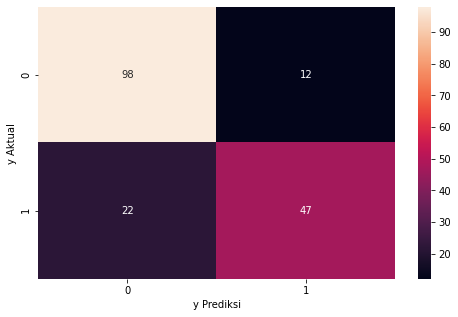

In [19]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

### **Interpretasi**

### **Precision**
Precision describes how accurate the model is in disti.nguishing which is actually positive from all positive predicted data.

Precision is suitable if the cost for False Positive is high. If we use metric precision, it means we are trying to minimize the number of false positives generated by the model. However, it should always be remembered that there is always a trade off between precision and recall.

So, in the case of Titanic, a false positive means that the passenger predicted to survive by the model, but did not actually survive. From the precision formula above and related to the Titanic case, the precision value means describing 'of all passengers classified as survivors, how many actually survived?'

A precision value of 80% means that 80% of the total passengers classified as safe (59 passengers), who actually survived were 47 passengers.

### **Recall**
The recall describes how many actual positives the model can predict.

Recall is suitable if the cost for False Negative is high. If we use the recall metric, it means we are trying to minimize the number of false negatives generated by the model.

In the case of the Titanic, a false negative meant that the predicted passenger did not survive, but actually did. That means, the recall value represents 'of all passengers who survived, how many people are classified as survivors?'

The recall value of 68% means that out of a total of 69 passengers who survived, only 47 passengers were classified as safe by the model.

### **F1-score**

In binary classification, the F1-score metric describes the harmonic average of the precision and recall values. The F1-score value depends on the precision and recall values ​​obtained. The higher the precision and recall values, the higher the F1-score value, and vice versa.

### **ROC AUC Curve**

ROC = probability curve

In binary classification, the ROC AUC curve is suitable when we are interested in both classes.

The ROC AUC score represents the score obtained from the ROC AUC curve or in other words the results of the calculation of the area under the curve. ROC AUC score describes how well the model can differentiate between classes.

Model classifiers that have a 100% correct percentage in their predictions will have an ROC AUC score = 1, while the worst is a score of 0.5 (same as random classifier).

In [20]:
y_proba = tree.predict_proba(X_test_preprocessed)
y_proba = y_proba[:, 1]

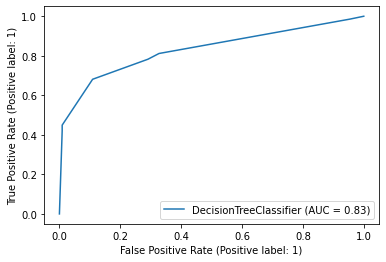

In [21]:
plot_roc_curve(tree, X_test_preprocessed, y_test);

Nilai AUC 83% berarti ada kemungkinan 83% model dapat membedakan antar kelas positif dan negatif.

In [22]:
roc_auc_score(y_test, y_proba)

0.8292490118577076

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)

In [24]:
pd.set_option('display.max_rows', None)
pd.DataFrame({
    'fpr':fpr,
    'tpr':tpr,
    'thresholds':thresholds    
})

,fpr,tpr,thresholds
0,0.000000,0.000000,1.949275
1,0.009091,0.420290,0.949275
2,0.009091,0.449275,0.846154
3,0.109091,0.681159,0.574468
4,0.290909,0.782609,0.389381
5,0.327273,0.811594,0.111111
6,0.954545,0.985507,0.091483
7,1.000000,1.000000,0.058824


### **Precision-Recall Curve**

Precision-Recall curves can help visualize how each threshold affects the performance of the classifier model.

The AP value generated on the Precision-Recall curve represents the average precision value of all thresholds.

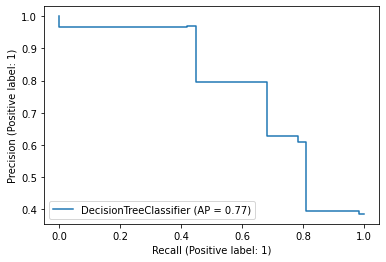

In [25]:
plot_precision_recall_curve(tree, X_test_preprocessed, y_test)

In [26]:
average_precision_score(y_test, y_proba)

0.7743706384473972

In [27]:
p, r, th = precision_recall_curve(y_test, y_proba)

In [28]:
th = list(th)
th.insert(0, 0)

In [29]:
th

[0,
 0.058823529411764705,
 0.0914826498422713,
 0.1111111111111111,
 0.3893805309734513,
 0.574468085106383,
 0.8461538461538461,
 0.9492753623188406]

In [30]:
pd.DataFrame({
    'recall':r,
    'precision':p,
    'threshold':th
})

,recall,precision,threshold
0,1.000000,0.385475,0.000000
1,0.985507,0.393064,0.058824
2,0.811594,0.608696,0.091483
3,0.782609,0.627907,0.111111
4,0.681159,0.796610,0.389381
5,0.449275,0.968750,0.574468
6,0.420290,0.966667,0.846154
7,0.000000,1.000000,0.949275


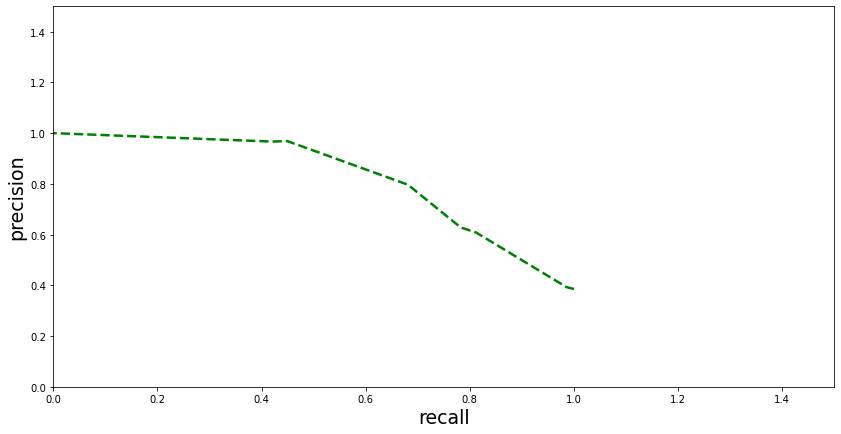

In [31]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, 'g--', linewidth=2.5)
    plt.xlabel('recall', fontsize=19)
    plt.ylabel('precision', fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(p, r)
plt.show()